In [18]:
import os, copy
import glob

import numpy as np
import scipy.optimize as so
import pandas as pd
import xarray as xr
import rioxarray as rxr

import netCDF4
import h5py
from osgeo import gdal

%matplotlib inline  
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet as cc

import prismapy.driver as driver
import prismapy

opj = os.path.join
prismapy.__version__

'1.0.0'

In [3]:
workdir = '/sat_data/satellite/acix-iii/Garda'
l1c = 'PRS_L1_STD_OFFL_20210721102700_20210721102705_0001.he5'
l2c = 'PRS_L2C_STD_20210721102700_20210721102705_0001.he5'

In [4]:
l1c_path = opj(workdir,l1c)
l2c_path = opj(workdir,l2c)

dc_l1c = driver.read_L1C_data(l1c_path,reflectance_unit=True)
#dc_l2c = driver.read_L2C_data(l2c_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


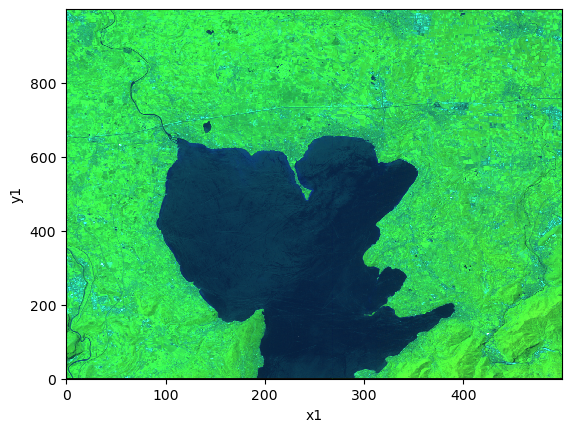

In [6]:
coarsening=2
brightness_factor = 3.5
(dc_l1c.Rtoa[:, ::coarsening, ::coarsening].isel(wl=[30,20,10])*brightness_factor).plot.imshow(rgb='wl')#, subplot_kws=dict(projection= l1c.proj))

## Example of exploiation: compute NDWI for water pixel masking


In [7]:
# Compute NDWI
green = dc_l1c.Rtoa.isel(wl=20)
nir = dc_l1c.Rtoa.isel(wl=55)
ndwi = (green - nir) / (green + nir)

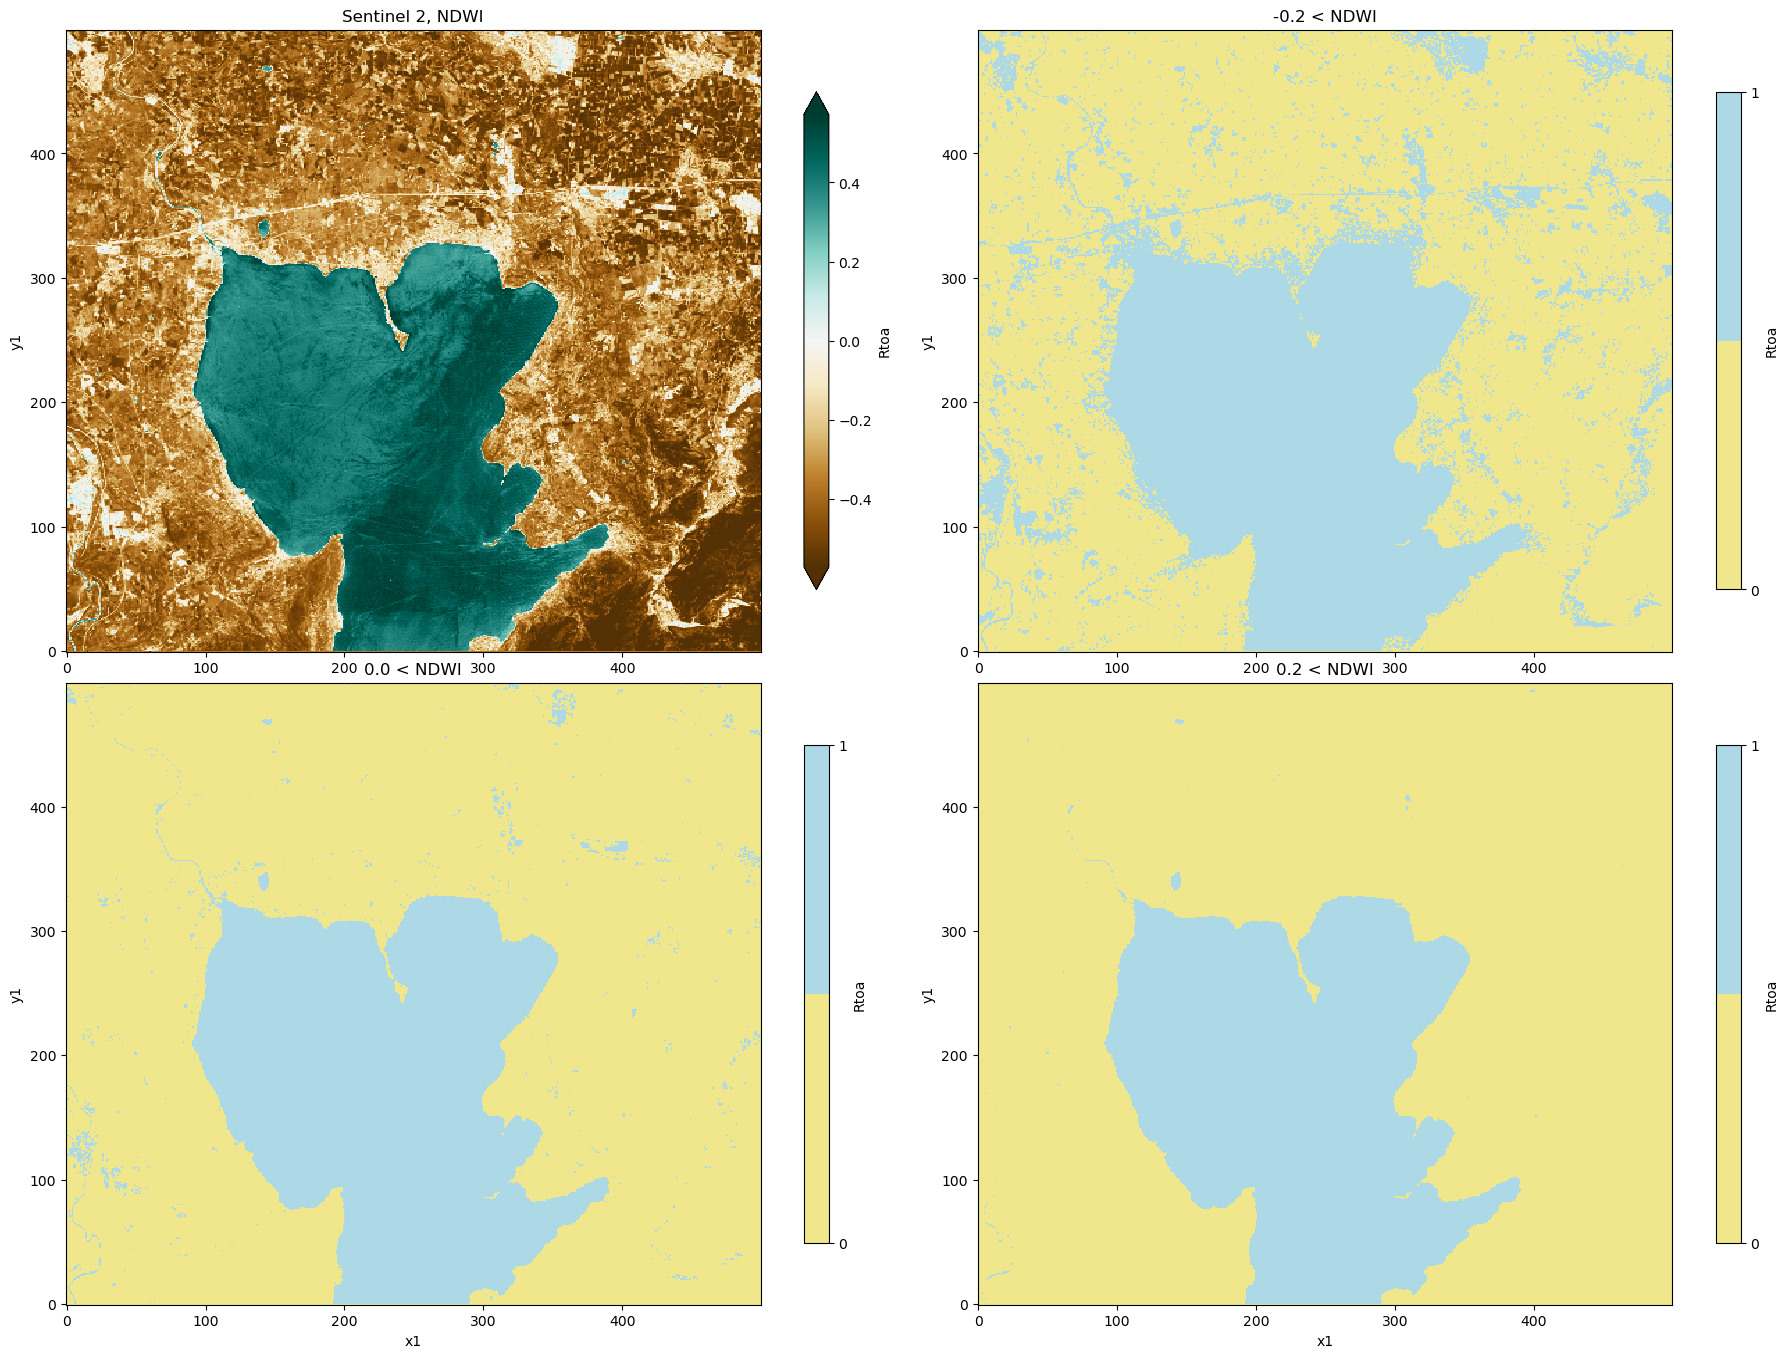

In [19]:
coarsening=2

# binary cmap
bcmap = mpl.colors.ListedColormap(['khaki', 'lightblue'])

def water_mask(ndwi, threshold=0):
    water = xr.where(ndwi > threshold, 1, 0)
    return water.where(~np.isnan(ndwi))

def plot_water_mask(ndwi,ax,threshold=0):
    water = water_mask(ndwi, threshold)
    #ax.set_extent(extent_val, proj)
    water.plot.imshow( cmap=bcmap,
                                  cbar_kwargs={'ticks': [0, 1], 'shrink': shrink})#extent=extent_val, transform=proj,
    ax.set_title(str(threshold)+' < NDWI')
    
fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.99,
                    hspace=0.05, wspace=0.05)
shrink = 0.8
    
ax = plt.subplot(2, 2, 1)#, projection=proj)
#ax.set_extent(extent_val, proj)
fig = ndwi[::coarsening, ::coarsening].plot.imshow(cmap=plt.cm.BrBG, robust=True,
                                   cbar_kwargs={'shrink': shrink})# extent=extent_val, transform=proj, 
# axes.coastlines(resolution='10m',linewidth=1)
ax.set_title('Sentinel 2, NDWI')

for i,threshold in enumerate([-0.2,0.,0.2]):
    ax = plt.subplot(2, 2, i+2)#, projection=proj)
    plot_water_mask(ndwi[::coarsening, ::coarsening],ax,threshold=threshold)

plt.show()



## Plot the top-of-atmosphere (TOA) radiance in mW/m2/nm

In [23]:
threshold=0.2
masked = dc_l1c.where(ndwi > threshold)

In [24]:
masked

<xarray.Dataset>
Dimensions:         (y1: 1000, x1: 1000, wl: 232)
Coordinates:
    lon             (x1, y1) float32 10.85 10.85 10.85 ... 10.36 10.36 10.36
    lat             (x1, y1) float32 45.59 45.59 45.59 ... 45.41 45.41 45.41
  * wl              (wl) float32 407.0 415.8 423.8 ... 2.49e+03 2.497e+03
Dimensions without coordinates: y1, x1
Data variables:
    Ltoa            (y1, x1, wl) float32 nan nan nan nan nan ... nan nan nan nan
    F0              (wl, y1, x1) float64 nan nan nan nan nan ... nan nan nan nan
    Rtoa            (y1, x1, wl) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask      (y1, x1) float64 nan nan nan nan nan ... nan nan nan nan nan
    sunglint_mask   (y1, x1) float64 nan nan nan nan nan ... nan nan nan nan nan
    landcover_mask  (y1, x1) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:       PRISMA L1C cube data
    L1C_product_name:  PRS_L1_STD_OFFL_20210721102700_20210721102705_0001.he5
    acquisition_date:  2021-07-21T10:27:00.923000
    sza:               27.702345
    saa:               150.24118

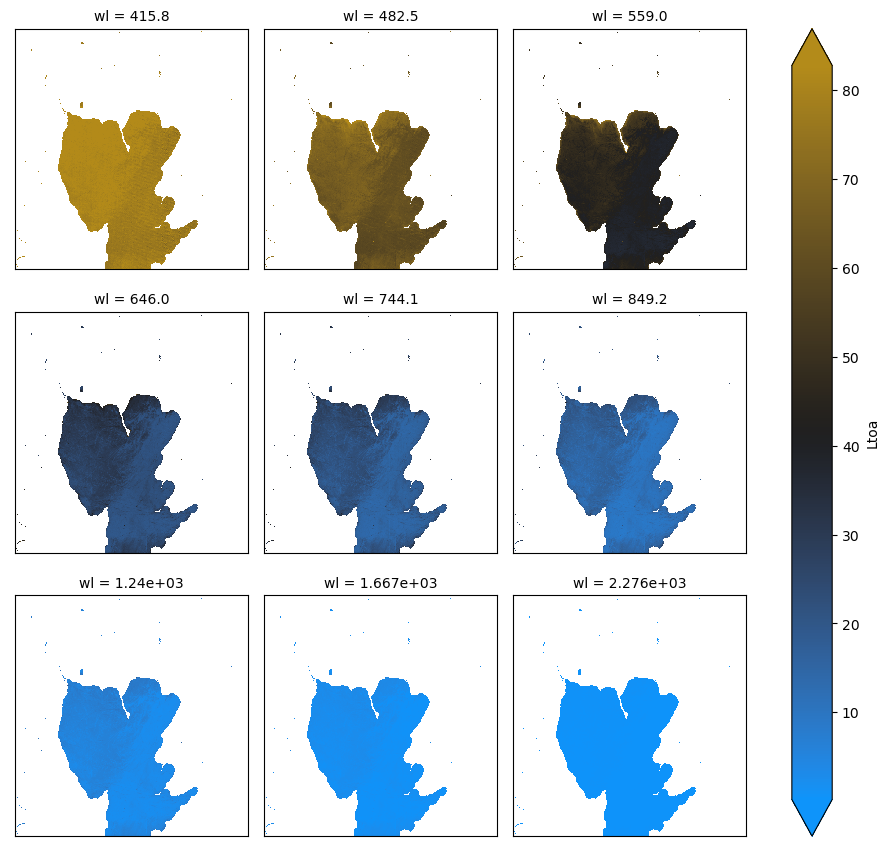

In [25]:

fig = masked.Ltoa.isel(wl=[1,10,20,30,40,50,90,130,200]).plot.imshow(col='wl',col_wrap=3,robust=True,cmap=cc.cm.bky)
for ax in fig.axs.flat:
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel('')
    ax.set_xlabel('')
fig

## Plot the top-of-atmosphere (TOA) reflectance

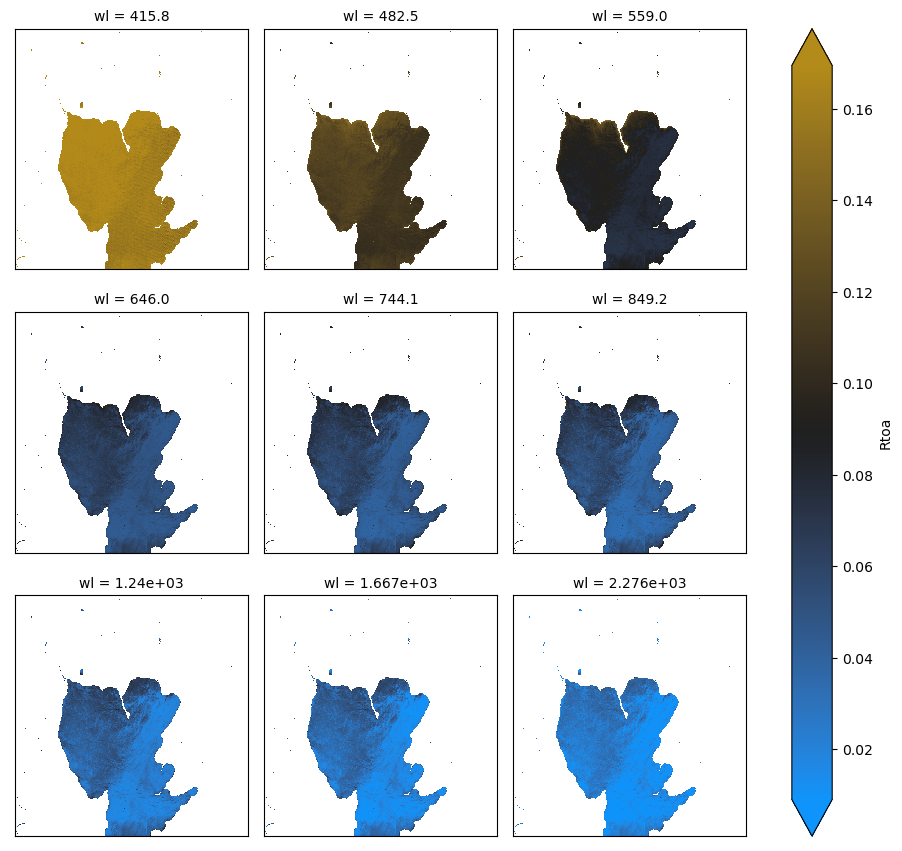

In [26]:
fig = masked.Rtoa.isel(wl=[1,10,20,30,40,50,90,130,200]).plot.imshow(col='wl',col_wrap=3,robust=True,cmap=cc.cm.bky)
for ax in fig.axs.flat:
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel('')
    ax.set_xlabel('')
fig